# Perform mps+dmft calculation on Anderson impurity model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import linalg 

In [2]:
# plot setting 
import matplotlib as mpl
from matplotlib import rcParams
from matplotlib import rc

plt.style.use('default')

rcParams[ 'axes.titlesize'] = 25
rcParams[ 'axes.labelsize'] = 25
rcParams[ 'lines.markersize'] = 5
rcParams[ 'xtick.labelsize'] = 22
rcParams[ 'ytick.labelsize'] = 22
rcParams[ 'legend.fontsize'] = 25
rcParams[ 'legend.frameon'] = True

# mpl.rc('font', family='sans-serif')
mpl.rc('text', usetex=True)

mpl.rcParams['text.latex.preamble'] = [
       r'\usepackage{amsmath}',
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
    
]  


In [3]:
# import sys
# sys.path.insert(0,"../input/mps-imp-wf")

In [4]:
from imp_chain_ham import *
from mps import *
from TEBD import TEBD_class # main solver
from parameter import parameter # parameter

from bath_generator import spectral

# Test one-chain free fermion

In [5]:

# --------------------------------------------------------
#                    parameter
# --------------------------------------------------------
# Set interaction four orbital
Dmax = 250 # max bound dimension

num_of_imp = int(4) # four imp
U_hubbard = 0.0 # density interaction
JH         = 0.0 # Hund's

U ={ '12':U_hubbard, '13':U_hubbard - 0.5 * JH, '14':U_hubbard, '23':U_hubbard, '24':U_hubbard - 0.5 * JH, '34':U_hubbard }
J = -0.5 * JH
ed = np.ones( num_of_imp ) * ( -1.5 * U_hubbard ) #fix half filling
E0 = 0.0
para = parameter(Dmax, ed, U, J,E0) # import para
para.tau = 5.0

# get bath
const_spec = spectral()
const_spec.constant_dos(600)
[vl, el, de] = const_spec.get_bath_coeff(200)
[w, rc] = const_spec.get_dos_from_para(vl, el, de, 1.0)
# vl = np.zeros(el.shape)
# el = np.zeros(vl.shape)


In [6]:
# --------------------------------------------------------
#                    initialization
# --------------------------------------------------------
# definte Ham
chain_ham = []
for i in range(0,4):
    ham = single_chain_ham(el, vl, 0.0)
    chain_ham.append(ham)

# chain mps
L_bath = len(el)
chain_mpo = []
for i in range(0,4):
    if( i% 2 == 0):
        if_bath_sign = True 
    else:
        if_bath_sign = False
    mps_ = mps(para, L_bath+1, if_bath_sign)
    chain_mpo.append(mps_)
# TEBD solver
tebd_ = TEBD_class(para)
int_gate = int_ham(para,para.tau/2.0)
tebd_.init(para)
tebd_.import_chain_ham(chain_ham)
tebd_.import_int_gate(int_gate, para.tau/2.0)

In [7]:
print(tebd_.chain_mpo[0].D)

[1 1 1 1 1]


In [8]:

# --------------------------------------------------------
#                    one chain fermion
#                     real time evolution
# --------------------------------------------------------
N_tau = 500
para.tau = 2.0
En = 9999
int_gate.update_dt(para.tau/2.0)
for i in range(0, N_tau):
    if( i%10 == 0 and i!=0 and para.tau > 0.02):
        para.tau = para.tau/2.0
    
    if( i%2 ==0):
        En_new = tebd_.time_evolution(para.tau, if_calculate_gnd_en = True)
        print("gnd energy = ",En_new)
        diff = np.abs( En - En_new )
        En = En_new
        if( diff < 1e-8 and i > N_tau/2):
            if( para.tau < 0.02 ):
                print("Solved")
                break 
            else:
                para.tau = para.tau/2.0       
    else:
         En_new = tebd_.time_evolution(para.tau, if_calculate_gnd_en = False)

gnd energy =  [[-4.81546818+0.j]]
gnd energy =  [[-5.76707914+0.j]]
gnd energy =  [[-5.89991241+0.j]]
gnd energy =  [[-5.91475653+0.j]]
gnd energy =  [[-5.91597586+0.j]]
gnd energy =  [[-5.94376308+0.j]]
gnd energy =  [[-5.94816447+0.j]]
gnd energy =  [[-5.94863113+0.j]]
gnd energy =  [[-5.94872767+0.j]]
gnd energy =  [[-5.94875183+0.j]]
gnd energy =  [[-5.95096224+0.j]]
gnd energy =  [[-5.95170346+0.j]]
gnd energy =  [[-5.95183121+0.j]]
gnd energy =  [[-5.95186903+0.j]]
gnd energy =  [[-5.95188353+0.j]]
gnd energy =  [[-5.95200032+0.j]]
gnd energy =  [[-5.95207731+0.j]]
gnd energy =  [[-5.9521003+0.j]]
gnd energy =  [[-5.95210951+0.j]]
gnd energy =  [[-5.9521139+0.j]]
gnd energy =  [[-5.95212039+0.j]]
gnd energy =  [[-5.95212628+0.j]]
gnd energy =  [[-5.95212928+0.j]]
gnd energy =  [[-5.95213098+0.j]]
gnd energy =  [[-5.95213203+0.j]]
gnd energy =  [[-5.95213277+0.j]]
gnd energy =  [[-5.95213334+0.j]]
gnd energy =  [[-5.95213376+0.j]]
gnd energy =  [[-5.95213407+0.j]]
gnd energy =  [[

In [9]:
tebd_.save_gnd()

In [10]:
tebd_.load_gnd()
imp_ind = 2

Nt = 10
t = []
gt_num = []
para.t = 0.02



tebd_.act_d_dag(imp_ind)


for i in range(0,Nt):
    t.append(i * para.t)
        
        

    gt = tebd_.trace_with_d(imp_ind)
    print("------------")
#     gt = chain_mpo[0].trace_()
    print("i, gt",i, gt)
    gt_num.append(gt)
    tebd_.time_evolution(1j * para.t, if_calculate_gnd_en = False)
#     tebd_.one_step_chain_projection(tebd_.chain_mpo[0], tebd_.chain_ham[0], 1j*para.t )


# tebd_.load_gnd()
# imp_ind = 0

# Nt = 10
# t = []
# gt_num = []
# para.t = 0.02





# for i in range(0,Nt):
#     t.append(i * para.t)
        
        

#     gt = tebd_.trace()
#     print("------------")
# #     gt = chain_mpo[0].trace_()
#     print("i, gt",i, gt)
#     print(np.exp( -1j * ( t[i] *(-5.952135))) )
#     gt_num.append(gt)
#     tebd_.time_evolution(1j * para.t, if_calculate_gnd_en = False)
# #     tebd_.one_step_chain_projection(tebd_.chain_mpo[0], tebd_.chain_ham[0], 1j*para.t )





------------
i, gt 0 [0.50001896+0.j]
------------
i, gt 1 [0.49748616+0.05013081j]
------------
i, gt 2 [0.489914+0.09974821j]
------------
i, gt 3 [0.47738091+0.1483442j]
------------
i, gt 4 [0.4600167+0.19542145j]
------------
i, gt 5 [0.43800115+0.24049857j]
------------
i, gt 6 [0.41156213+0.2831151j]
------------
i, gt 7 [0.38097319+0.32283638j]
------------
i, gt 8 [0.34655062+0.35925803j]
------------
i, gt 9 [0.30865014+0.39201017j]


In [11]:
def get_eig( vl, el):
    # get eigen value of the ham 
    nc = len(vl)
    ham = np.zeros( (nc+1,nc+1), dtype = np.float32)
    np.fill_diagonal( ham[1:,1:], el)
    ham[0,1:] = vl 
    ham[1:,0] = vl 
    ham[0,0]  = 0.00
    eg,eg_v = linalg.eig(ham)
   
    return [eg,eg_v] 

def cdag_c(t, eg,eg_v):
    # <psi | d e^{-iHt} d^dag |psi>
    vv = eg_v * np.conj(eg_v)     
    vv = vv[0,:]*(np.exp(-1j * eg * t)) 
    vv = vv*(eg > 0.0)
    gt = np.sum(vv)
    en = np.sum(eg * ( eg < 0.0) )
    en = np.exp( -1j * t * en )
    gt = gt * en 
#     gt = gt *  np.exp(-1j*t * np.sum( eg * (eg<0.0) ) ) 
#     print(gt)
    return gt

eg,eg_v = get_eig(vl,el)
print("Gnd energy = ",4.0 * np.sum(eg * (eg < 0.0 )))
eg_each_chain = np.sum(eg * (eg < 0.0 )) 

Gnd energy =  (-5.9521355628967285+0j)


In [12]:
gt_ana = []
for t_it in t:
    gt =  cdag_c(t_it, eg, eg_v) 
    gt = gt * np.exp(- 1j * t_it * eg_each_chain * 3.0)
#     gt =  np.exp(-4j * t_it * eg_each_chain)
    gt_ana.append( gt )

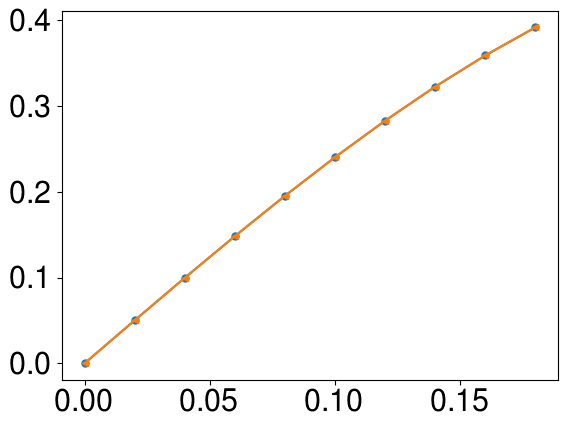

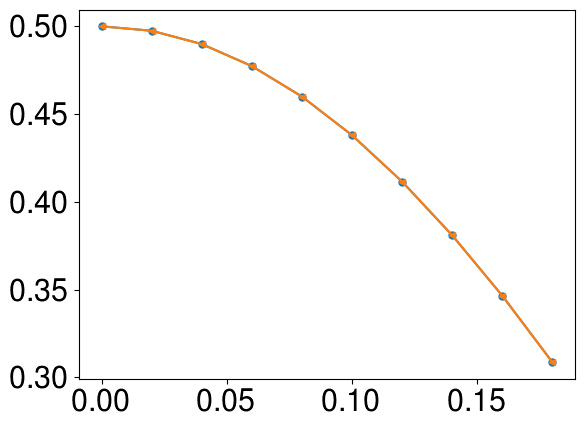

In [13]:
t = np.asarray(t)
gt_num = np.asarray(gt_num)
gt_ana = np.asarray(gt_ana)
plt.plot(t, np.imag( gt_num ) ,'-o')
plt.plot(t, np.imag( gt_ana ),'-<')
plt.show()

plt.plot(t, np.real( gt_num ) ,'-o')
plt.plot(t, np.real( gt_ana ) ,'-<')
plt.show()

# Test interaction w/o femion bath

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import linalg 

# plot setting 
import matplotlib as mpl
from matplotlib import rcParams
from matplotlib import rc

plt.style.use('default')

rcParams[ 'axes.titlesize'] = 25
rcParams[ 'axes.labelsize'] = 25
rcParams[ 'lines.markersize'] = 5
rcParams[ 'xtick.labelsize'] = 22
rcParams[ 'ytick.labelsize'] = 22
rcParams[ 'legend.fontsize'] = 25
rcParams[ 'legend.frameon'] = True

# mpl.rc('font', family='sans-serif')
mpl.rc('text', usetex=True)

mpl.rcParams['text.latex.preamble'] = [
       r'\usepackage{amsmath}',
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
    
]  

from imp_chain_ham import *
from mps import *
from TEBD import TEBD_class # main solver
from parameter import parameter # parameter

from bath_generator import spectral


In [15]:

# Set interaction four orbital 
Dmax = 128 # max bound dimension 

num_of_imp = int(4) # four imp
U_hubbard = 2.0 # density interaction
JH         = 1.0 # Hund's


U ={ '12':U_hubbard, '13':U_hubbard - 0.5 * JH, '14':U_hubbard, '23':U_hubbard, '24':U_hubbard - 0.5 * JH, '34':U_hubbard }
J = -0.5 * JH 
ed = np.ones( num_of_imp ) * ( -1.5 * U_hubbard ) #fix half filling 
ed[0] = 0.6
E0 = 0
para = parameter(Dmax, ed, U, J,E0) # import para 

In [19]:
vl = [0.0]
el = [0.0]
# zero bath 
para.L_total= len(vl) + 1

# --------------------------------------------------------
#                    initialization
# --------------------------------------------------------


# definte Ham
chain_ham = []
for i in range(0,4):
    ham = single_chain_ham(el, vl, 0.0)
    chain_ham.append(ham)

# chain mps
L_bath = len(el)
chain_mpo = []
for i in range(0,4):
    if( i% 2 == 0):
        if_bath_sign = True 
    else:
        if_bath_sign = False
    mps_ = mps(para, L_bath+1, if_bath_sign)
    chain_mpo.append(mps_)
# TEBD solver
tebd_ = TEBD_class(para)
int_gate = int_ham(para,para.tau/2.0)
tebd_.init(para)
tebd_.import_chain_ham(chain_ham)
tebd_.import_int_gate(int_gate, para.tau/2.0)


In [20]:

N_tau = 500
para.tau = 2.0
En = 9999
int_gate.update_dt(para.tau/2.0)
for i in range(0, N_tau):
    if( i%10 == 0 and i!=0 and para.tau > 0.02):
        para.tau = para.tau/2.0
    
    if( i%2 ==0):
        En_new = tebd_.time_evolution(para.tau, if_calculate_gnd_en = True)
        print("gnd energy = ",En_new)
        diff = np.abs( En - En_new )
        En = En_new
        if( diff < 1e-8 and i > N_tau/2):
            if( para.tau < 0.02 ):
                print("Solved")
                break 
            else:
                para.tau = para.tau/2.0       
    else:
         En_new = tebd_.time_evolution(para.tau, if_calculate_gnd_en = False)

gnd energy =  [[-4.27862501+0.j]]
gnd energy =  [[-4.49050042+0.j]]
gnd energy =  [[-4.49972189+0.j]]
gnd energy =  [[-4.49999172+0.j]]
gnd energy =  [[-4.49999975+0.j]]
gnd energy =  [[-4.49999998+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy =  [[-4.5+0.j]]
gnd energy = 

In [21]:
tebd_.save_gnd( )

In [22]:
tebd_.load_gnd()
imp_ind = 0

Nt = 50
t = []
gt_num = []
para.t = 0.02



tebd_.act_d_dag(imp_ind)

for i in range(0,Nt):
    t.append(i * para.t)
    gt = tebd_.trace_with_d(imp_ind)
    print("------------")
#     gt = chain_mpo[0].trace_()
    print("i, gt",i, gt)
    gt_num.append(gt)
    tebd_.time_evolution(1j * para.t, if_calculate_gnd_en = False)
#     tebd_.one_step_chain_projection(tebd_.chain_mpo[0], tebd_.chain_ham[0], 1j*para.t )
    


------------
i, gt 0 [1.+0.j]
------------
i, gt 1 [0.999998-0.002j]
------------
i, gt 2 [0.999992-0.00399999j]
------------
i, gt 3 [0.999982-0.00599996j]
------------
i, gt 4 [0.999968-0.00799991j]
------------
i, gt 5 [0.99995-0.00999983j]
------------
i, gt 6 [0.999928-0.01199971j]
------------
i, gt 7 [0.999902-0.01399954j]
------------
i, gt 8 [0.999872-0.01599932j]
------------
i, gt 9 [0.999838-0.01799903j]
------------
i, gt 10 [0.99980001-0.01999867j]
------------
i, gt 11 [0.99975801-0.02199823j]
------------
i, gt 12 [0.99971201-0.0239977j]
------------
i, gt 13 [0.99966202-0.02599707j]
------------
i, gt 14 [0.99960803-0.02799634j]
------------
i, gt 15 [0.99955003-0.0299955j]
------------
i, gt 16 [0.99948804-0.03199454j]
------------
i, gt 17 [0.99942206-0.03399345j]
------------
i, gt 18 [0.99935207-0.03599222j]
------------
i, gt 19 [0.99927809-0.03799086j]
------------
i, gt 20 [0.99920011-0.03998933j]
------------
i, gt 21 [0.99911813-0.04198765j]
------------
i, gt

In [23]:
gt_ana = int_gate.d_dag_t_d(t)

/anaconda3/envs/py3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


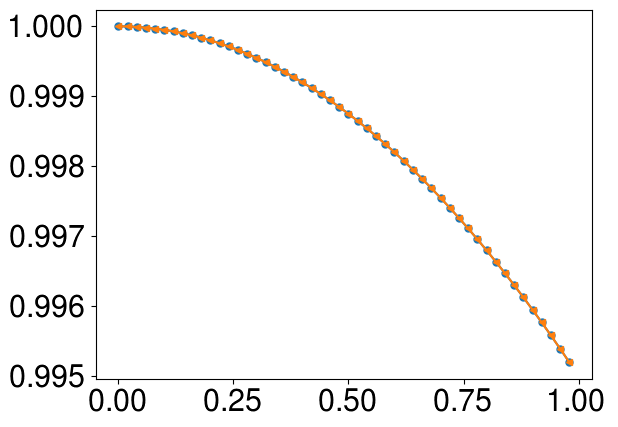

In [24]:
plt.plot(t, gt_num,'-o')
plt.plot(t, gt_ana, '-<')
plt.show()

# Test total

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import linalg 

# plot setting 
import matplotlib as mpl
from matplotlib import rcParams
from matplotlib import rc

plt.style.use('default')

rcParams[ 'axes.titlesize'] = 25
rcParams[ 'axes.labelsize'] = 25
rcParams[ 'lines.markersize'] = 5
rcParams[ 'xtick.labelsize'] = 22
rcParams[ 'ytick.labelsize'] = 22
rcParams[ 'legend.fontsize'] = 25
rcParams[ 'legend.frameon'] = True

# mpl.rc('font', family='sans-serif')
mpl.rc('text', usetex=True)

mpl.rcParams['text.latex.preamble'] = [
       r'\usepackage{amsmath}',
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
    
]  

from imp_chain_ham import *
from mps import *
from TEBD import TEBD_class # main solver
from parameter import parameter # parameter

from bath_generator import spectral


In [29]:

# Set interaction four orbital 
Dmax = 256 # max bound dimension 

num_of_imp = int(4) # four imp
U_hubbard = 1.0# density interaction
JH         = 0.3 # Hund's


U ={ '12':U_hubbard, '13':U_hubbard - 0.5 * JH, '14':U_hubbard, '23':U_hubbard, '24':U_hubbard - 0.5 * JH, '34':U_hubbard }
J = -0.5 * JH 
ed = np.ones( num_of_imp ) * ( -1.5 * U_hubbard ) #fix half filling 
E0 = 0
para = parameter(Dmax, ed, U, J,E0) # import para



# get bath 
const_spec = spectral()
const_spec.constant_dos(2)
[vl, el, de] = const_spec.get_bath_coeff(2)
[w, rc] = const_spec.get_dos_from_para(vl, el, de, 1.0)

para.L_total= len(vl) + 1

# --------------------------------------------------------
#                    initialization
# --------------------------------------------------------


# definte Ham
chain_ham = []
for i in range(0,4):
    ham = single_chain_ham(el, vl, 0.0)
    chain_ham.append(ham)

# chain mps
L_bath = len(el)
chain_mpo = []
for i in range(0,4):
    if( i% 2 == 0):
        if_bath_sign = True 
    else:
        if_bath_sign = False
    mps_ = mps(para, L_bath+1, if_bath_sign)
    chain_mpo.append(mps_)
# TEBD solver
tebd_ = TEBD_class(para)
int_gate = int_ham(para,para.tau/2.0)
tebd_.init(para)
tebd_.import_chain_ham(chain_ham)
tebd_.import_int_gate(int_gate, para.tau/2.0)


In [30]:
from ed import ed_solver
import time 
time_st = time.time()
ed_ = ed_solver(para,el,vl) # initalize ed 
ed_.construct_ham()
time_1 = time.time()
print("time = ", (time_1-time_st)/60.0)
ed_.get_eigen_system()
print("time = ", (time.time() -time_1)/60.0)

time =  0.0024459004402160645
time =  0.00015541712443033854


In [31]:
N_tau = 500
para.tau = 2.0
En = 9999
int_gate.update_dt(para.tau/2.0)
for i in range(0, N_tau):
    if( i%10 == 0 and i!=0 and para.tau > 0.02):
        para.tau = para.tau/2.0
    
    if( i%2 ==0):
        En_new = tebd_.time_evolution(para.tau, if_calculate_gnd_en = True)
        print("gnd energy = ",En_new)
        diff = np.abs( En - En_new )
        En = En_new
        if( diff < 1e-8 and i > N_tau/2):
            if( para.tau < 0.02 ):
                print("Solved")
                break 
            else:
                para.tau = para.tau/2.0       
    else:
         En_new = tebd_.time_evolution(para.tau, if_calculate_gnd_en = False)
            
tebd_.save_gnd( )

gnd energy =  [[-4.45406727+0.j]]
gnd energy =  [[-5.29263887+0.j]]
gnd energy =  [[-5.2952696+0.j]]
gnd energy =  [[-5.29527044+0.j]]
gnd energy =  [[-5.29527044+0.j]]
gnd energy =  [[-5.57547186+0.j]]
gnd energy =  [[-5.57686524+0.j]]
gnd energy =  [[-5.57686547+0.j]]
gnd energy =  [[-5.57686547+0.j]]
gnd energy =  [[-5.57686547+0.j]]
gnd energy =  [[-5.63577819+0.j]]
gnd energy =  [[-5.63860834+0.j]]
gnd energy =  [[-5.63862932+0.j]]
gnd energy =  [[-5.63862955+0.j]]
gnd energy =  [[-5.63862955+0.j]]
gnd energy =  [[-5.64436097+0.j]]
gnd energy =  [[-5.64548482+0.j]]
gnd energy =  [[-5.64555491+0.j]]
gnd energy =  [[-5.64556087+0.j]]
gnd energy =  [[-5.64556141+0.j]]
gnd energy =  [[-5.64587921+0.j]]
gnd energy =  [[-5.64604247+0.j]]
gnd energy =  [[-5.64607303+0.j]]
gnd energy =  [[-5.64608051+0.j]]
gnd energy =  [[-5.64608258+0.j]]
gnd energy =  [[-5.64609631+0.j]]
gnd energy =  [[-5.64610897+0.j]]
gnd energy =  [[-5.64611381+0.j]]
gnd energy =  [[-5.64611585+0.j]]
gnd energy =  [

In [32]:
print("Gnd energy = ", ed_.get_gnd_energy())
print(ed_.eg[0:3])

Gnd energy =  -5.646120044089302
[-5.64612004 -4.69142614 -4.69142614]


In [33]:
tebd_.load_gnd()
imp_ind = 3

Nt = 10
t = []
gt_num = []
para.t = 0.02



tebd_.act_d_dag(imp_ind)

for i in range(0,Nt):
    t.append(i * para.t)
    gt = tebd_.trace_with_d(imp_ind)
    print("------------")
#     gt = chain_mpo[0].trace_()
    print("i, gt",i, gt)
    gt_num.append(gt)
    tebd_.time_evolution(1j * para.t, if_calculate_gnd_en = False)
#     tebd_.one_step_chain_projection(tebd_.chain_mpo[0], tebd_.chain_ham[0], 1j*para.t )
    

------------
i, gt 0 [0.48954697+0.j]
------------
i, gt 1 [0.48748365+0.04454406j]
------------
i, gt 2 [0.48131167+0.088704j]
------------
i, gt 3 [0.4710848+0.13209907j]
------------
i, gt 4 [0.45689214+0.1743552j]
------------
i, gt 5 [0.43885733+0.21510831j]
------------
i, gt 6 [0.41713747+0.25400748j]
------------
i, gt 7 [0.39192174+0.29071801j]
------------
i, gt 8 [0.36342973+0.32492436j]
------------
i, gt 9 [0.33190953+0.35633292j]


In [34]:
gt_ana = ed_.get_c_t_cdag_gnd(t,0)

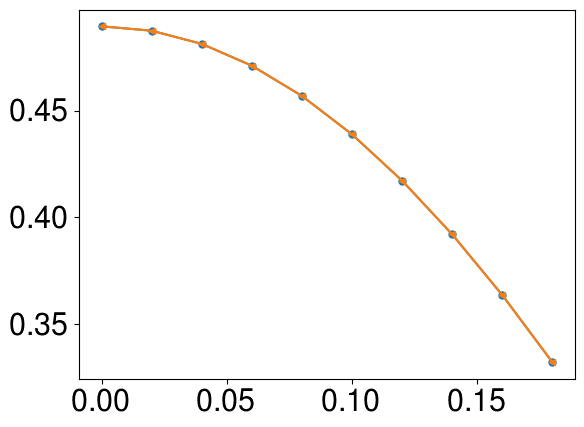

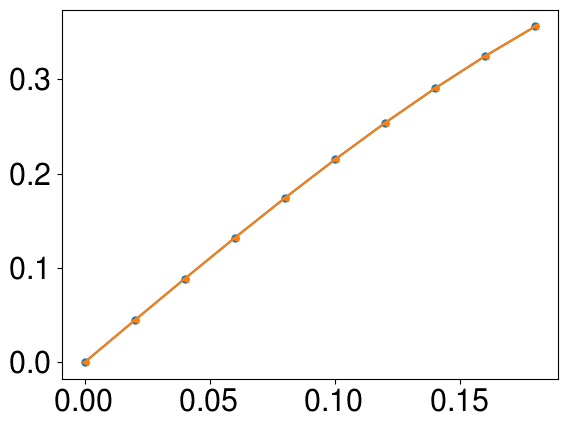

In [35]:
plt.plot(t, np.real(gt_num), '-o')
plt.plot(t, np.real(gt_ana),'-<')
plt.show()
plt.plot(t, np.imag(gt_num), '-o')
plt.plot(t, np.imag(gt_ana),'-<')
plt.show()

In [36]:
tebd_.load_gnd()
imp_ind = 3

Nt = 10
t = []
gt_num = []
para.t = 0.02



tebd_.act_d(imp_ind)

for i in range(0,Nt):
    t.append(i * para.t)
    gt = tebd_.trace_with_d_dag(imp_ind)
    print("------------")
#     gt = chain_mpo[0].trace_()
    print("i, gt",i, gt)
    gt_num.append(gt)
    tebd_.time_evolution(1j * para.t, if_calculate_gnd_en = False)
#     tebd_.one_step_chain_projection(tebd_.chain_mpo[0], tebd_.chain_ham[0], 1j*para.t )
gt_ana = ed_.get_cdag_t_c_gnd(t,0)  

------------
i, gt 0 [0.51045303+0.j]
------------
i, gt 1 [0.50834111+0.0459997j]
------------
i, gt 2 [0.50202345+0.09160963j]
------------
i, gt 3 [0.49155413+0.13644335j]
------------
i, gt 4 [0.47702282+0.18012112j]
------------
i, gt 5 [0.45855393+0.22227315j]
------------
i, gt 6 [0.43630559+0.26254278j]
------------
i, gt 7 [0.41046826+0.30058954j]
------------
i, gt 8 [0.38126309+0.3360921j]
------------
i, gt 9 [0.34894003+0.36875101j]


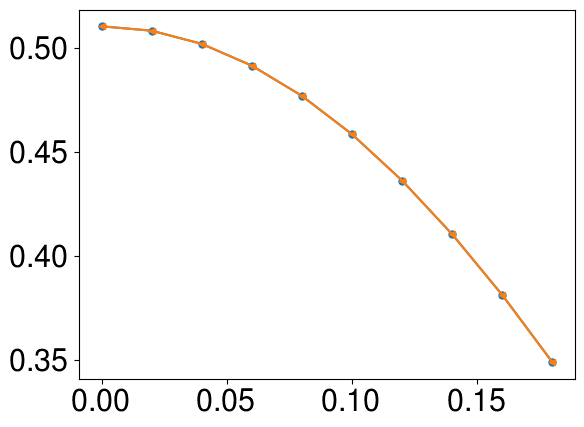

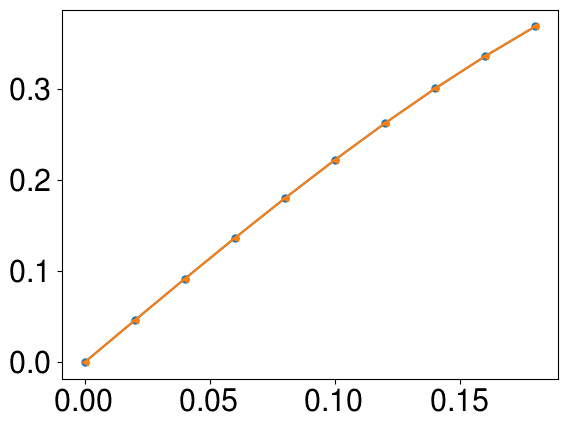

In [37]:
plt.plot(t, np.real(gt_num), '-o')
plt.plot(t, np.real(gt_ana),'-<')
plt.show()
plt.plot(t, np.imag(gt_num), '-o')
plt.plot(t, np.imag(gt_ana),'-<')
plt.show()